In [1]:
import sys
import cv2
import numpy as np
#sys.path.insert(0, '/home/ubuntu/caffe/python')
sys.path.insert(0, '/home/ubuntu/py-faster-rcnn/caffe-fast-rcnn/python')
import matplotlib 
matplotlib.use('Agg')
import caffe
import pprint
sys.path.insert(0, '/home/ubuntu/py-faster-rcnn/lib')
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect
import os
from sklearn.manifold import TSNE
from fast_rcnn.nms_wrapper import nms
import matplotlib.pyplot as plt
from sklearn import decomposition
import heapq
#import bhtsne
%matplotlib inline

In [94]:
from PIL import Image
from matplotlib import offsetbox
import matplotlib.patches as mpatches
import random
test_name = 'test'
test_files = []
with open('/home/ubuntu/try1/data/ImageSets/'+test_name+'.txt') as f:
    num_lines = 0
    for file_ in f.readlines():
        num_lines += 1
        test_files.append(file_.strip())
''' 
image_path = '/home/ubuntu/try1/data/Images/'
path = '/home/ubuntu/try1/results/'+test_name
for file_index, file_ in enumerate(test_files):
    print file_
    #get numpy array of image 
    try:
        extension='.tif'
        pil_im = np.asarray(Image.open(os.path.join(image_path, file_+extension)))
    except: 
        extension='.jpg' 
        pil_im = np.asarray(Image.open(os.path.join(image_path, file_+extension)))          
    pil_im = pil_im.copy()
'''
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None, coordinates=False, images=False):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(20, 20),dpi=160,facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    patches = []
    for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1],str(CLASSES[int(y[i])]),color=plt.cm.Set1(y[i] / len(CLASSES)),fontdict={'weight': 'bold', 'size': 5})
        plt.plot(X[i, 0], X[i, 1],marker='o',markersize=6,color=plt.cm.Set1(y[i] / len(CLASSES)),markeredgecolor='none')
    #legend
    for yi in range(int(max(y))):
        patches.append(mpatches.Patch(color=plt.cm.Set1(yi*1.0 / len(CLASSES)), label=str(CLASSES[yi])))
    plt.legend(handles=patches)
    plt.xticks([]), plt.yticks([])
        
    if title is not None:
        plt.title(title)
    #include images
    if coordinates is not False:
        shown_images = np.array([[1., 1.]])  # just something big
        test_file_index = 0
        cumsum = len(coordinates[0])
        for i in range(X.shape[0]):
            #if i >= cumsum:
            #    test_file_index += 1
            #    cumsum += len(coordinates[test_file_index])
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 5e-4:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            test_file_index = images[i]
            filename = test_files[test_file_index]
            img = Image.open(os.path.join('/home/ubuntu/try1/data/Images', filename+'.jpg'))
            coord = coordinates[i]#coordinates[test_file_index][i - (cumsum-len(coordinates[test_file_index]))]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img.crop((int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3]))).resize((30,30))),X[i], pad=0.2, bboxprops = 
                            dict(color=plt.cm.Set1(y[i] / len(CLASSES))))
            ax.add_artist(imagebox)
            
    


In [3]:
# Must turn this off to prevent issues when digging into the net blobs to
# pull out features (tricky!)
cfg.DEDUP_BOXES = 0
cfg.TEST.BBOX_REG = False

faster_rcnn_dir = '/home/ubuntu/py-faster-rcnn'
data_dir = '/home/ubuntu/try1/data'

image_files = []
with open(os.path.join(data_dir, 'ImageSets','test.txt')) as f:
    filenames = f.readlines()
num_images = len(filenames)

cfg_file = os.path.join(faster_rcnn_dir, 'experiments/cfgs/faster_rcnn_end2end.yml')
if cfg_file is not None:
    cfg_from_file(cfg_file)
print('Using config:')
pprint.pprint(cfg)


model_file = os.path.join(faster_rcnn_dir, 'output/faster_rcnn_end2end/train/vgg_cnn_m_1024_faster_rcnn_iter_100000.caffemodel')
deploy_prototxt = os.path.join(faster_rcnn_dir, 'models/VGG_CNN_M_1024/faster_rcnn_end2end/test.prototxt')
net = caffe.Net(deploy_prototxt, model_file, caffe.TEST)
net.name = os.path.splitext(os.path.basename(model_file))[0]

#extract feature vector from this layer
layer = 'fc7' 
#if layer not in net.blobs:
#    raise TypeError("Invalid layer name: " + layer)



Using config:
{'DEDUP_BOXES': 0,
 'EPS': 1e-14,
 'EXP_DIR': 'faster_rcnn_end2end',
 'GPU_ID': 0,
 'PIXEL_MEANS': array([[[ 102.9801,  115.9465,  122.7717]]]),
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/ubuntu/py-faster-rcnn',
 'TEST': {'BBOX_REG': False,
          'HAS_RPN': True,
          'MAX_SIZE': 1600,
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'selective_search',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 600,
          'RPN_PRE_NMS_TOP_N': 12000,
          'SCALES': [1200],
          'SVM': False},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_SIZE': 128,
           'BBOX_INSIDE_WEIGHTS': [1.0, 1.0, 1.0, 1.0],
           'BBOX_NORMALIZE_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZE_STDS': [0.1, 0.1, 0.2, 0.2],
           'BBOX_NORMALIZE_TARGETS': True,
           'BBOX_NORMALIZE_TARGETS_PRECOMPUTED': True,
           'BBOX_REG': True,
           'BBOX_THRESH': 0.5,
           'BG_THRESH_HI': 0.5,
          

In [4]:
#X: samples x features, 
#y: corresponding labels (according to the model output)
X = np.array([]).reshape(0,1024)
y = np.array([])
CONF_THRESH = 0.8
NMS_THRESH = 0.3
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')

for i in xrange(num_images):
    input_image_file = filenames[i].strip()
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates = np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations])
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img, coordinates)
    
    #get features from layer
    feat = net.blobs[layer].data  
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        #print cls, cls_ind
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
         
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        #print keep
        cls_boxes = cls_boxes[keep, :]
        cls_scores = cls_scores[keep]
        cls_feat = feat[keep,:]
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        #print keep, dets[keep,:]
        #dets = dets[keep, :]
        
        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
        X = np.concatenate((X, cls_feat[keep,:]), axis=0)
        y = np.append(y, np.array([cls_ind]*len(keep)))



0 g8_t1_up/g6010119


NameError: name 'net' is not defined

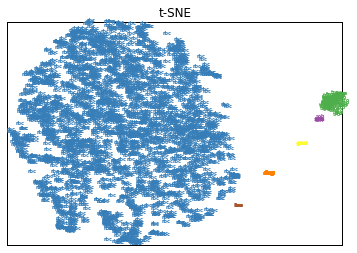

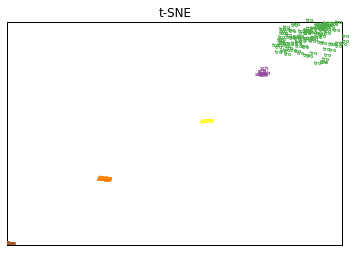

In [39]:
model = TSNE(n_components=2, init='pca', learning_rate=500)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE")
plt.show()

idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE")
plt.show()

In [77]:
print X_tsne.shape, y.shape

(3632, 2) (3632,)


In [83]:
print X[0], y[0]
print X[1], y[1]

[ 0.63158473  0.66888527] 1.0
[ 0.82750073  0.96985611] 1.0


Computing PCA projection


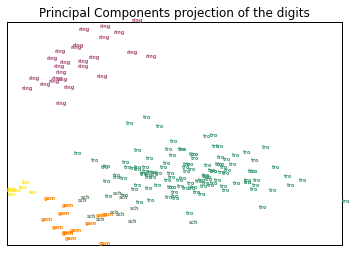

In [125]:
print("Computing PCA projection")
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, y,
               "Principal Components projection of the digits")


In [123]:
print X[0:4,:]
print y[0:4]
print np.linalg.norm(X[3,:]-X[2,:]), np.linalg.norm(X[0,:]-X[2,:]), np.linalg.norm(X[1,:]-X[2,:])
print 'keep',keep
print boxes
print feat[keep]

[[ 0.          0.          0.         ...,  0.          0.17672095  0.        ]
 [ 0.          0.          0.31423366 ...,  0.23640758  0.65428114  0.        ]
 [ 0.          0.          0.81775099 ...,  0.          0.09576081
   0.15418215]
 [ 0.16469368  0.          0.43200785 ...,  0.          0.          0.27212104]]
[ 2.  3.  4.  4.]
10.6774539679 17.1994096621 20.4291156471
keep []
[[   72.0192337    408.58624268   178.89767456 ...,   408.58624268
    178.89767456   519.28912354]
 [ 1274.47583008   871.43261719  1398.45214844 ...,   871.43261719
   1398.45214844   987.48632812]
 [  778.5043335    408.04611206   895.97869873 ...,   408.04611206
    895.97869873   515.06323242]
 ..., 
 [ 1165.6307373   1136.9185791   1265.84313965 ...,  1136.9185791
   1265.84313965  1199.        ]
 [    0.           279.97463989   130.56930542 ...,   279.97463989
    130.56930542   505.88613892]
 [   42.6852417    160.6222229    173.50012207 ...,   160.6222229
    173.50012207   256.26303101]]
[]


In [81]:
#X: samples x features, 
#y: corresponding labels (according to the ground truth)
X = np.array([]).reshape(0,1024)
y = np.array([])
y_image = np.array([])
NMS_THRESH = 0.3
SCORE_THRESH = 0.65
max_per_image = 200
max_per_set = 100 * num_images
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')
MIN_OVERLAP = 0.5
thresh = -np.inf * np.ones(len(CLASSES))
top_scores = [[] for _ in xrange(len(CLASSES))]
box_coordinates = np.array([]).reshape(0,4)
coordinates = []
input_image_file = []
images = []
num_images = 50
for i in xrange(num_images):
    input_image_file.append(filenames[i].strip())
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file[i]+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file[i]+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates.append(np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations]))
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    #print len(coordinates[i]), coordinates[i]
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img, coordinates)
    
    #get features from layer
    feat = net.blobs[layer].data  
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        print cls
        keep = np.where(scores[:, cls_ind] >= max(SCORE_THRESH, thresh[cls_ind]))[0]
        #print len(keep)
        cls_boxes = boxes[keep, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[keep, cls_ind]
        cls_feat = feat[keep,:]
        
        top_inds = np.argsort(-cls_scores)[:max_per_image]
        #print len(top_inds)
        cls_scores = cls_scores[top_inds]
        cls_boxes = cls_boxes[top_inds, :]
        cls_feat = cls_feat[top_inds, :]
        
        # push new scores onto the minheap
        for val in cls_scores:
            heapq.heappush(top_scores[cls_ind], val)
            
        # if we've collected more than the max number of detection,
        # then pop items off the minheap and update the class threshold
        if len(top_scores[cls_ind]) > max_per_set:
                while len(top_scores[cls_ind]) > max_per_set:
                    heapq.heappop(top_scores[cls_ind])
                thresh[cls_ind] = top_scores[cls_ind][0]
                print 'more'
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        print len(keep)
        #print keep, dets[keep,:]
        dets = dets[keep, :]
        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
    
        #for each detection, match with closest ground truth; if overlap less than threshold, consider ground truth to be background
        for det in dets:
            _boxes = det[:4]
            ov_max = -float("inf")
            for ngt, gt_boxes in enumerate(coordinates[i]):
                iw = min(_boxes[2], gt_boxes[2]) - max(_boxes[0], gt_boxes[0]) + 1
                ih = min(_boxes[3], gt_boxes[3]) - max(_boxes[1], gt_boxes[1]) + 1
                if iw > 0 and ih > 0:
                    #compute overlap as area of intersection / area of union
                    ua = (_boxes[2] - _boxes[0] + 1)*(_boxes[3] - _boxes[1] + 1) + (gt_boxes[2] - gt_boxes[0] + 1)*(gt_boxes[3] - gt_boxes[1] + 1) - iw*ih
                    ov = iw*ih*1.0/ua
                    if ov > ov_max:
                        ov_max = ov
                        ngt_max = ngt
            if ov_max >= MIN_OVERLAP:
                if str(difficult[ngt_max]) != 'True': 
                    y = np.append(y, np.array([CLASSES.index(labels[ngt_max])]))
                else:
                    print difficult[ngt_max], len(difficult), len(coordinates)
                    y = np.append(y, np.array([len(CLASSES)-1]))
            else:
                print ov_max
                y = np.append(y, np.array([0]))
        images.extend([i for x in range(len(keep))])
        box_coordinates = np.concatenate((box_coordinates, cls_boxes[keep, :]), axis = 0)
        X = np.concatenate((X, cls_feat[keep,:]), axis=0)
        y_image = np.append(y_image, np.array([i]*len(keep)))


0 ['g8_t1_up/g6010119']
rbc
35
tro
1
True 38 1
sch
0
ring
1
True 38 1
gam
0
leu
0
1 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115']
rbc
57
tro
3
sch
0
ring
0
gam
1
leu
3
0.067343457919
2 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115', 'g8_t1_up/g6010027']
rbc
more
83
tro
3
True 94 3
sch
0
ring
0
gam
0
leu
0
3 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115', 'g8_t1_up/g6010027', 'g8_t1_up/g6010020']
rbc
more
70
tro
1
sch
0
ring
2
gam
0
leu
0
4 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115', 'g8_t1_up/g6010027', 'g8_t1_up/g6010020', 'g8_t1_up/g6010149']
rbc
more
72
tro
4
sch
0
ring
4
True 89 5
gam
1
leu
0
5 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115', 'g8_t1_up/g6010027', 'g8_t1_up/g6010020', 'g8_t1_up/g6010149', 'g8_t1_up/g6010194']
rbc
more
70
tro
3
sch
1
ring
0
gam
1
leu
0
6 ['g8_t1_up/g6010119', 'g8_t1_up/g6010115', 'g8_t1_up/g6010027', 'g8_t1_up/g6010020', 'g8_t1_up/g6010149', 'g8_t1_up/g6010194', 'g8_t1_up/g6010232']
rbc
more
64
tro
1
True 80 7
sch
0
ring
0
gam
0
leu
0
7 ['g8_t1_up/g6010119', 'g8_t1_up/g

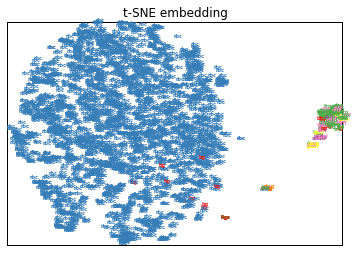

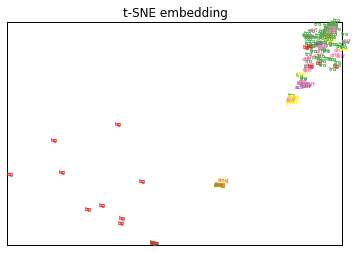

In [45]:

model = TSNE(n_components=2, init='pca', learning_rate=200, n_iter=5000)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding", coordinates)
plt.show()
 
idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()



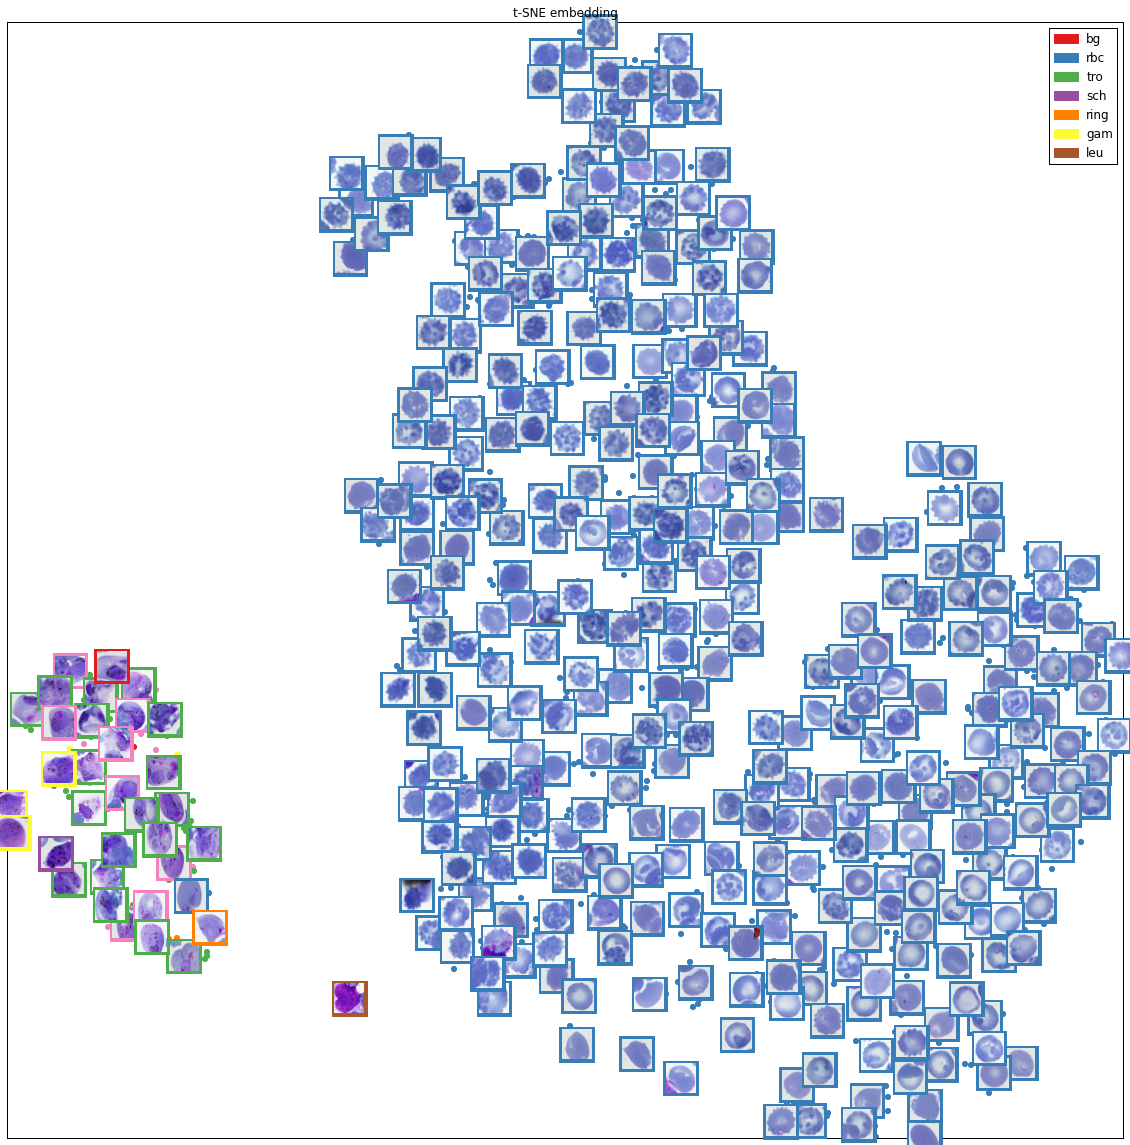

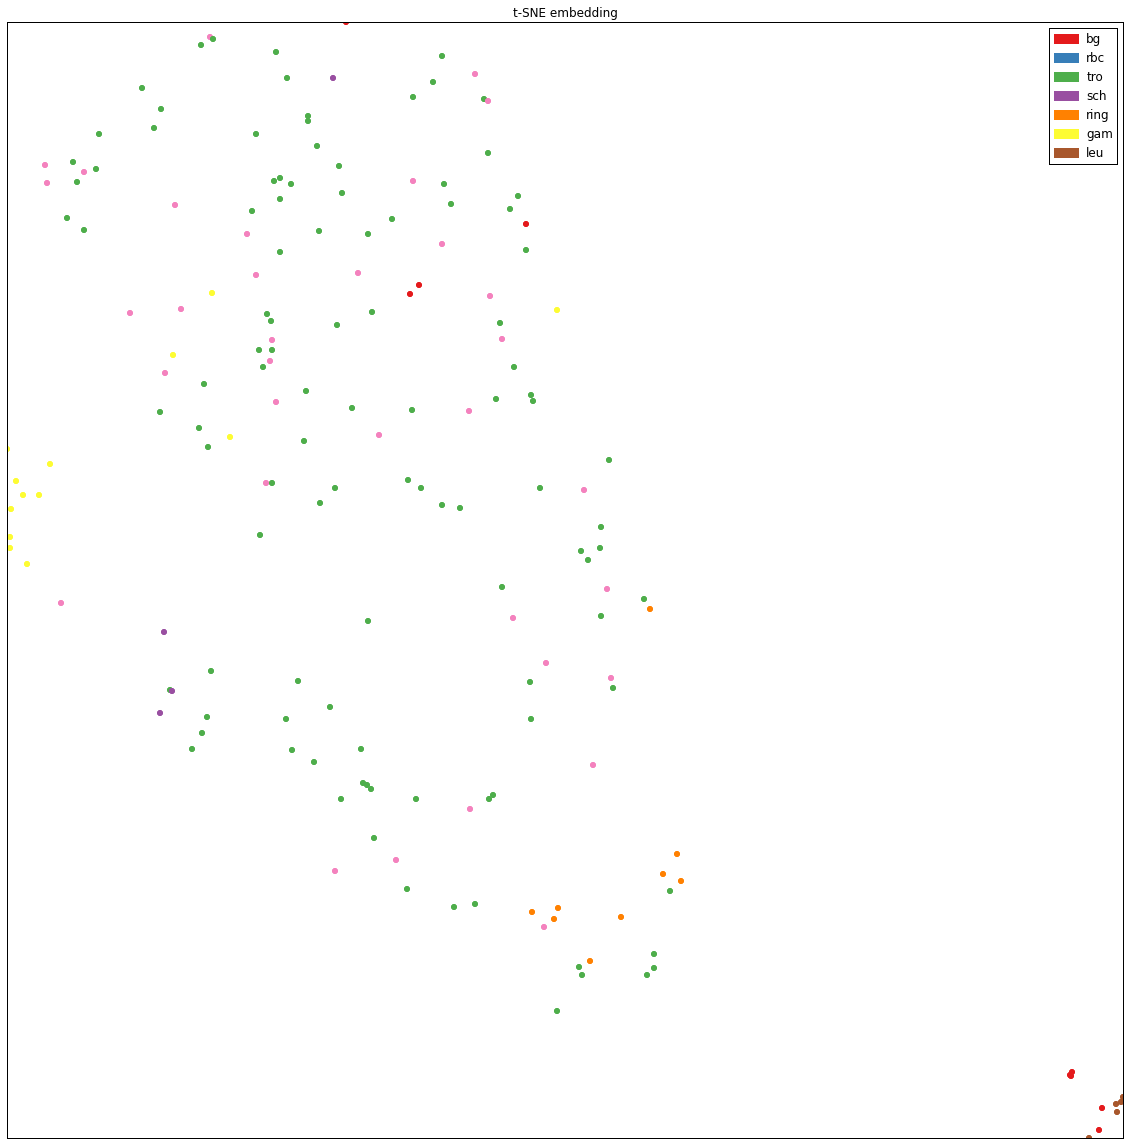

In [95]:
import bhtsne
X_tsne = bhtsne.tsne(X)
#model = TSNE(n_components=2, init='pca', learning_rate=200, n_iter=200)
#X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding", box_coordinates, images)
plt.show()
 
idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(X_tsne[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()

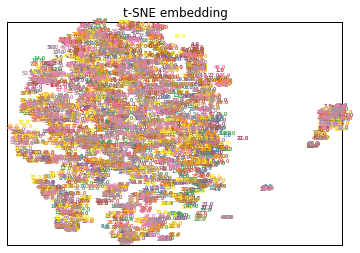

In [49]:
def plot_embedding_imnum(X, y_image, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_image[i]),
                 color=plt.cm.Set1(y_image[i] / max(y_image)),
                 fontdict={'weight': 'bold', 'size': 5})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
plot_embedding_imnum(X_tsne, y_image, "t-SNE embedding")
plt.show()

In [50]:
#X: samples x features, 
#y: corresponding labels (according to the model output)
#thresholding is done as above
X = np.array([]).reshape(0,1024)
y = np.array([])
y_image = np.array([])
NMS_THRESH = 0.3
SCORE_THRESH = 0.65
max_per_image = 200
max_per_set = 100 * num_images
CLASSES = ('bg', 'rbc', 'tro', 'sch', 'ring', 'gam', 'leu', 'diff')
classes = ('rbc', 'tro', 'sch', 'ring', 'gam', 'leu')
MIN_OVERLAP = 0.5
thresh = -np.inf * np.ones(len(CLASSES))
top_scores = [[] for _ in xrange(len(CLASSES))]
for i in xrange(num_images):
    input_image_file = filenames[i].strip()
    print i, input_image_file
    img = cv2.imread(os.path.join(data_dir, 'Images', input_image_file+'.jpg'))
    #extract single objects
    with open(os.path.join(data_dir, 'Annotations', input_image_file+'.txt')) as fa:
        annotations = fa.readlines()
    coordinates = np.array([np.array(map(int, annotation.strip().split(' ')[:-2])) for annotation in annotations])
    labels = [annotation.strip().split(' ')[-2] for annotation in annotations]
    difficult = [annotation.strip().split(' ')[-1] for annotation in annotations]
    
    #runs image through net (Detect object classes in an image given object proposals.)
    scores, boxes = im_detect(net, img, coordinates)
    
    #get features from layer
    feat = net.blobs[layer].data  
    for cls in classes:
        cls_ind = CLASSES.index(cls)
        print cls
        keep = np.where(scores[:, cls_ind] >= max(SCORE_THRESH, thresh[cls_ind]))[0]
        #print len(keep)
        cls_boxes = boxes[keep, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[keep, cls_ind]
        cls_feat = feat[keep,:]
        
        top_inds = np.argsort(-cls_scores)[:max_per_image]
        #print len(top_inds)
        cls_scores = cls_scores[top_inds]
        cls_boxes = cls_boxes[top_inds, :]
        cls_feat = cls_feat[top_inds, :]
        
        # push new scores onto the minheap
        for val in cls_scores:
            heapq.heappush(top_scores[cls_ind], val)
            
        # if we've collected more than the max number of detection,
        # then pop items off the minheap and update the class threshold
        if len(top_scores[cls_ind]) > max_per_set:
                while len(top_scores[cls_ind]) > max_per_set:
                    heapq.heappop(top_scores[cls_ind])
                thresh[cls_ind] = top_scores[cls_ind][0]
                print 'more'
        
        dets = np.hstack((cls_boxes,cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)

        #print len(coordinates), X.shape, cls_feat[keep,:].shape
        #output = net.forward()
    
        X = np.concatenate((X, cls_feat[keep,:]), axis=0)
        y = np.append(y, np.array([cls_ind]*len(keep)))


0 g8_t1_up/g6010106
rbc
tro
sch
ring
gam
leu
1 g8_t1_up/g6010133
rbc
tro
sch
ring
gam
leu
2 g8_t1_up/g6010196
rbc
tro
sch
ring
gam
leu
3 g8_t1_up/g6010153
rbc
tro
sch
ring
gam
leu
4 g8_t1_up/g6010091
rbc
tro
sch
ring
gam
leu
5 g8_t1_up/g6010159
rbc
tro
sch
ring
gam
leu
6 g8_t1_up/g6010273
rbc
tro
sch
ring
gam
leu
7 g8_t1_up/g6010017
rbc
tro
sch
ring
gam
leu
8 g8_t1_up/g6010003
rbc
tro
sch
ring
gam
leu
9 g8_t1_up/g6010072
rbc
tro
sch
ring
gam
leu
10 g8_t1_up/g6010168
rbc
tro
sch
ring
gam
leu
11 g8_t1_up/g6010287
rbc
tro
sch
ring
gam
leu
12 g8_t1_up/g6010138
rbc
tro
sch
ring
gam
leu
13 g8_t1_up/g6010282
rbc
tro
sch
ring
gam
leu
14 g8_t1_up/g6010152
rbc
tro
sch
ring
gam
leu
15 g8_t1_up/g6010210
rbc
tro
sch
ring
gam
leu
16 g8_t1_up/g6010126
rbc
tro
sch
ring
gam
leu
17 g8_t1_up/g6010137
rbc
tro
sch
ring
gam
leu
18 g8_t1_up/g6010008
rbc
tro
sch
ring
gam
leu
19 g8_t1_up/g6010149
rbc
tro
sch
ring
gam
leu
20 g8_t1_up/g6010170
rbc
tro
sch
ring
gam
leu
21 g8_t1_up/g6010117
rbc
tro
sch
ring
gam
le

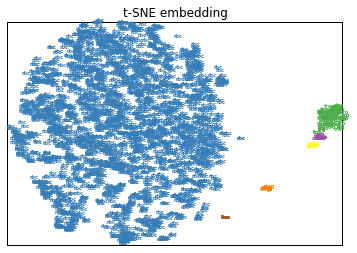

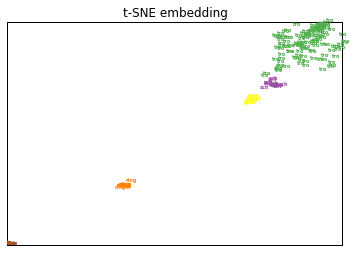

In [51]:
model = TSNE(n_components=2, init='pca', learning_rate=500)
X_tsne = model.fit_transform(X) 
plot_embedding(X_tsne, y, "t-SNE embedding")
plt.show()

idx_noRBC = [i for i in range(len(y)) if y[i] != 1]
plot_embedding(model.fit_transform(X)[idx_noRBC, :], y[idx_noRBC], "t-SNE embedding")
plt.show()